
LangChain and its packages like langchain-openai, langchain_community, and langchainhub enable advanced agent-based workflows using large language models (LLMs). These tools integrate with services like chromadb for embedding retrieval and tiktoken for managing LLM input limits, while pymupdf aids in extracting content from PDFs for information retrieval.

Here, we will focus on reports from SwissRe, utilizing LangChain's capabilities to streamline data extraction and analysis from their sustainability reports, improving report generation and enhancing the transparency of sustainability tracking

This notebook has been adapted with insights from the RAG Tutorials by Lance Martin at LangChain. A heartfelt thank you to him for his valuable contributions and for creating these schematics on different RAG techniques!


## Environment

`(1) Packages`


In [3]:
! pip install -qU langchain_community tiktoken langchain-openai langchainhub chromadb langchain pymupdf

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 62.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 67.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 604.0/604.0 kB 44.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 83.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 59.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.6/19.6 MB 75.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 273.8/273.8 kB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.6/94.6 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 7.0 MB/s eta 0:00:00
  

`(2) Setting up google drive, environment and necessary imports`

In [6]:
import os
from uuid import uuid4
from google.colab import userdata
from google.colab import drive
import warnings
import numpy as np
import tiktoken

from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader, PyMuPDFLoader
from langchain_community.vectorstores import Chroma
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain import hub

# Ignore warnings
warnings.filterwarnings("ignore")

# Mount Google Drive
drive.mount('/content/drive')

# Set working directory
os.chdir('/content/drive/MyDrive/ColabNotebooks/LangChain-RAG')
print(os.getcwd())

# Set API keys
OPENAI_API_KEY = userdata.get('OPENAI_API_KEY')
LANGCHAIN_API_KEY = userdata.get('LANGCHAIN_API_KEY')

os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY
os.environ["openai_api_key"] = OPENAI_API_KEY

# Folder for reports
reports_folder = "./data/reports/Sustainability"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/ColabNotebooks/LangChain-RAG


## Part 1: Overview of different RAG techniques
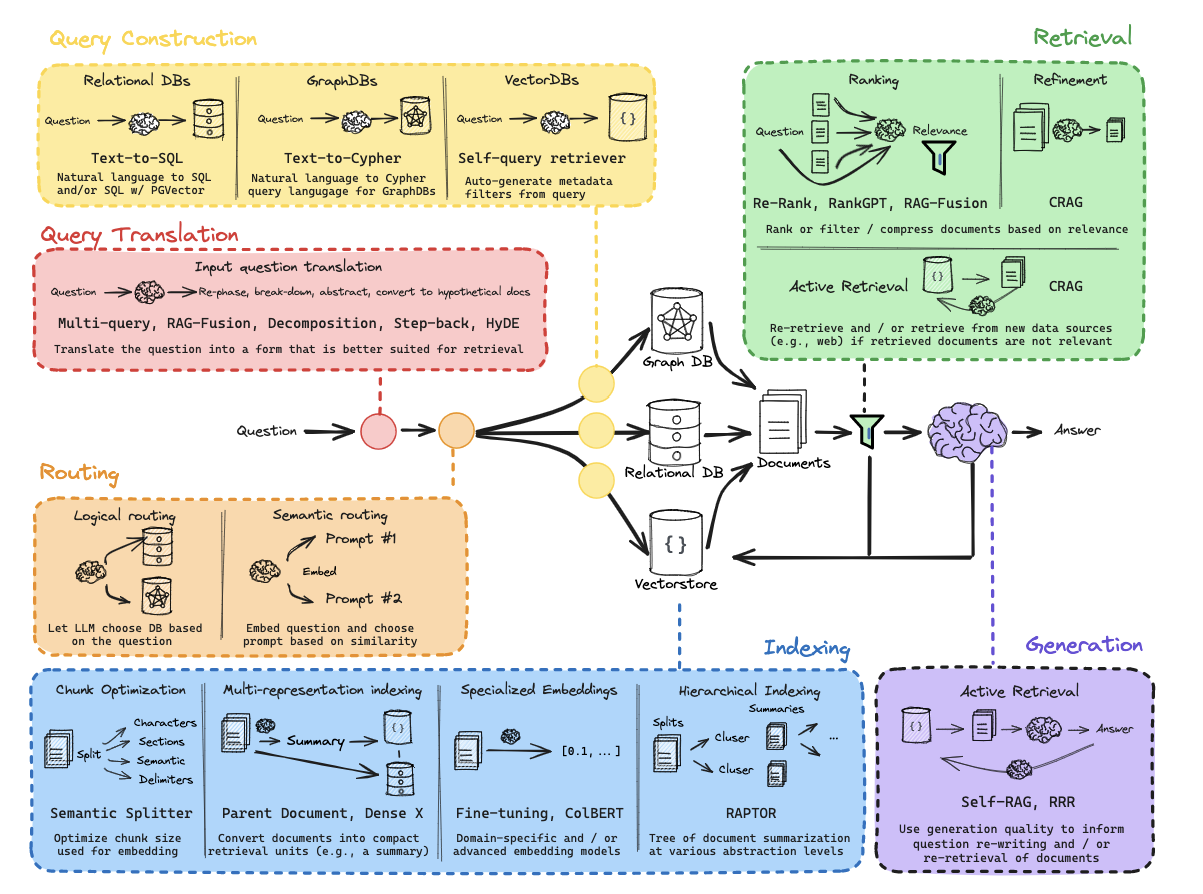


In [5]:
#### INDEXING ####

# Load reports
documents = []

for file_name in os.listdir(reports_folder):
    if file_name.endswith(".pdf"):
        file_path = os.path.join(reports_folder, file_name)
        loader = PyMuPDFLoader(file_path)
        documents.extend(loader.load())

# Split
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
splits = text_splitter.split_documents(documents)


# Embed
embedding = OpenAIEmbeddings(openai_api_key=OPENAI_API_KEY)
vectorstore = Chroma.from_documents(documents=splits, embedding=embedding)

retriever = vectorstore.as_retriever()

#### RETRIEVAL and GENERATION ####

# Prompt
prompt = hub.pull("rlm/rag-prompt")

# LLM
llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0,openai_api_key=OPENAI_API_KEY)

# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

# Chain
rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

# Question
rag_chain.invoke("How is biodiversity risk for SwissRe different from Blackrock?")

"Swiss Re does not prioritize biodiversity in its operations or investments, viewing it as non-material due to its limited direct impact and small office footprint. In contrast, BlackRock has a more comprehensive approach to biodiversity risk, integrating it into their investment strategies and considering it a material issue. Therefore, the key difference lies in Swiss Re's minimal focus on biodiversity compared to BlackRock's active engagement with the topic."

## Part 2: Indexing

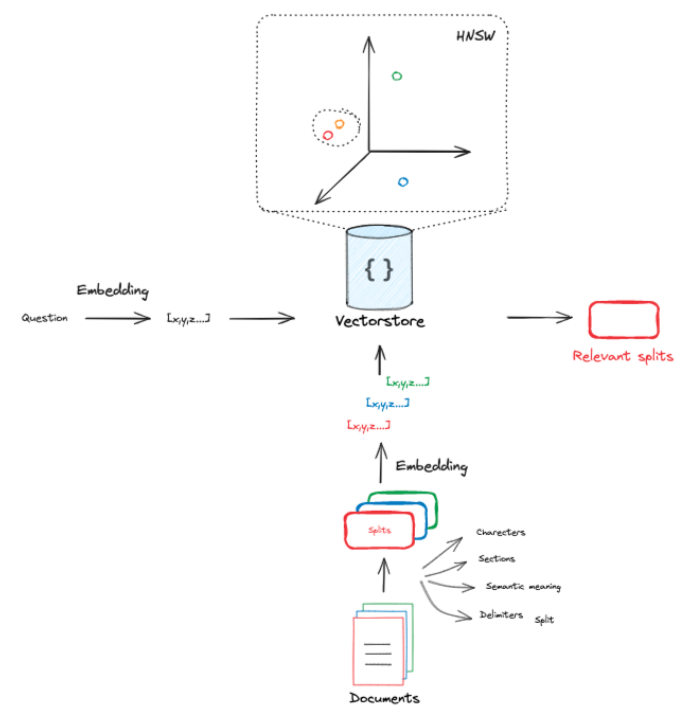

In [7]:
# Documents
question = "What is biodiversity risk for Blackrock?"
document = "Sustainability Report."

In [8]:
def num_tokens_from_string(string: str, encoding_name: str) -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.get_encoding(encoding_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens


In [9]:
from langchain_openai import OpenAIEmbeddings
embd = OpenAIEmbeddings(openai_api_key=OPENAI_API_KEY)
query_result = embd.embed_query(question)
document_result = embd.embed_query(document)


In [10]:

def cosine_similarity(vec1, vec2):
    dot_product = np.dot(vec1, vec2)
    norm_vec1 = np.linalg.norm(vec1)
    norm_vec2 = np.linalg.norm(vec2)
    return dot_product / (norm_vec1 * norm_vec2)

similarity = cosine_similarity(query_result, document_result)
print("Cosine Similarity:", similarity)

Cosine Similarity: 0.7808803430661303


[Splitter](https://python.langchain.com/docs/how_to/recursive_text_splitter/)

This text splitter is ideal for general use, splitting text based on a list of characters in order until the segments are small enough. The default sequence is ["\n\n", "\n", " ", ""], which helps keep paragraphs, sentences, and words intact for better semantic coherence.

In [11]:
os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY

# Load all PDFs in the Reports folder
reports_folder = "./data/reports/Sustainability"
documents = []

for file_name in os.listdir(reports_folder):
    if file_name.endswith(".pdf"):
        file_path = os.path.join(reports_folder, file_name)
        loader = PyMuPDFLoader(file_path)
        documents.extend(loader.load())

# Initialize text splitter
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=300,
    chunk_overlap=50
)

# Split documents
splits = text_splitter.split_documents(documents)

# Embed
embedding = OpenAIEmbeddings(openai_api_key=OPENAI_API_KEY)
vectorstore = Chroma.from_documents(documents=splits, embedding=embedding)

retriever = vectorstore.as_retriever(search_kwargs={"k": 3})



## Part 3: Retrieval

In [12]:
docs = retriever.get_relevant_documents("What are different sector-specific policies for ESG risk referrals?")

In [13]:
docs=retriever.invoke("What are different sector-specific policies for ESG risk referrals?")

## Part 4: Generation

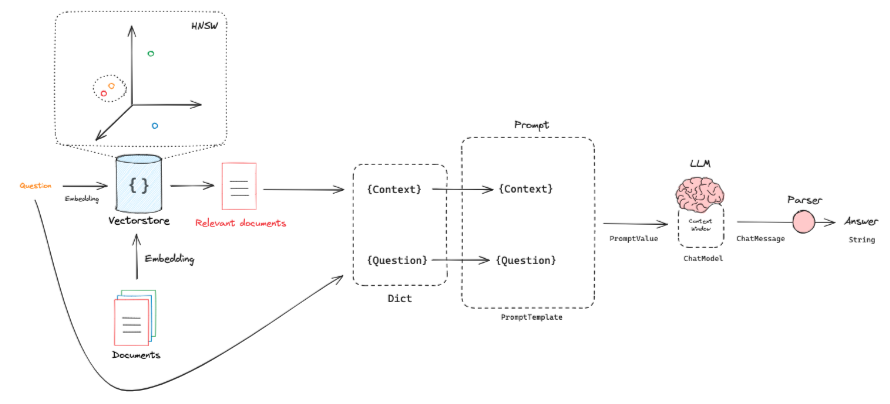

In [14]:
from langchain_openai import ChatOpenAI
from langchain.prompts import ChatPromptTemplate

# Prompt
template = """Answer the question based only on the following context:
{context}

Question: {question}
"""

prompt = ChatPromptTemplate.from_template(template)
prompt

ChatPromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template='Answer the question based only on the following context:\n{context}\n\nQuestion: {question}\n'), additional_kwargs={})])

In [15]:
# LLM
llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0)

In [16]:
# Chain
chain = prompt | llm

In [17]:
# Run
import re
response=chain.invoke({"context":docs,"question":"What are different sector-specific policies for ESG risk referrals submitted to SwissRe?"})
cleaned_content = re.sub(r'\\n+', ' ', response.content).replace('\n\n1.', ' ')
cleaned_content


'The sector-specific policies for ESG risk referrals submitted to Swiss Re include the following:  Agriculture, Forestry and Food\n2. Defence\n3. Hydro Dams\n4. Mining\n5. Nuclear Materials Non-Proliferation\n6. Oil and Gas\n7. Thermal Coal'

In [18]:
from langchain import hub
prompt_hub_rag = hub.pull("rlm/rag-prompt")

In [19]:
prompt_hub_rag

ChatPromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, metadata={'lc_hub_owner': 'rlm', 'lc_hub_repo': 'rag-prompt', 'lc_hub_commit_hash': '50442af133e61576e74536c6556cefe1fac147cad032f4377b60c436e6cdcb6e'}, messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:"), additional_kwargs={})])

[RAG chains](https://python.langchain.com/docs/how_to/sequence/)

In [20]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough

rag_chain = (
    {"context": retriever, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

rag_chain.invoke("What are different sector-specific policies for ESG risk referrals submitted to SwissRe?")

'The sector-specific policies for ESG risk referrals submitted to Swiss Re include the following sectors:\n\n1. Agriculture, Forestry and Food\n2. Defence\n3. Hydro Dams\n4. Mining\n5. Nuclear Materials Non-Proliferation\n6. Oil and Gas\n7. Thermal Coal\n\nThese policies are developed for sectors that are particularly exposed to sustainability risks.'

# Query Transformations

Query transformations are a set of approaches focused on re-writing and / or modifying questions for retrieval.

| Technique     | Purpose/Objective                                | Potential Examples                                                                 |
|---------------|--------------------------------------------------|-----------------------------------------------------------------------------------|
| Multi-query   | Retrieve data from various sections              | CO2 reduction targets, ESG metrics                                                |
| RAG-Fusion    | Combine data from different sources              | Climate-risk metrics with performance indicators, Underwriting + Investment data   |
| Decomposition | Break down complex topics into sub-queries       | Carbon reduction strategies, Climate-related disclosures                          |
| Step-back     | Evaluate alignment with external standards       | Sustainability governance, ESG risk management                                    |
| HyDE          | Generate hypothetical future projections         | GHG emission reduction predictions, Impact of new policies on targets             |

### Query Transformation Prompt

In [21]:
from langchain.prompts import ChatPromptTemplate

# Multi Query: Different Perspectives
template = """You are an AI language model assistant. Your task is to generate five
different versions of the given user question to retrieve relevant documents from a vector
database. By generating multiple perspectives on the user question, your goal is to help
the user overcome some of the limitations of the distance-based similarity search.
Provide these alternative questions separated by newlines. Original question: {question}"""
prompt_perspectives = ChatPromptTemplate.from_template(template)

from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI

generate_queries = (
    prompt_perspectives
    | ChatOpenAI(temperature=0, openai_api_key=OPENAI_API_KEY)
    | StrOutputParser()
    | (lambda x: x.split("\n"))
)

from langchain.load import dumps, loads

def get_unique_union(documents: list[list]):
    """ Unique union of retrieved docs """
    # Flatten list of lists, and convert each Document to string
    flattened_docs = [dumps(doc) for sublist in documents for doc in sublist]
    # Get unique documents
    unique_docs = list(set(flattened_docs))
    # Return
    return [loads(doc) for doc in unique_docs]

# Retrieve
question = "What are targets described for scope 1 and scope 2 GHG emissions for SwissRe and BlackRock?"
retrieval_chain = generate_queries | retriever.map() | get_unique_union
docs = retrieval_chain.invoke({"question":question})
len(docs)

7

In [22]:
from operator import itemgetter
from langchain_openai import ChatOpenAI
from langchain_core.runnables import RunnablePassthrough

# RAG
template = """Answer the following question based on this context:

{context}

Question: {question}
"""

prompt = ChatPromptTemplate.from_template(template)

llm = ChatOpenAI(temperature=0)

final_rag_chain = (
    {"context": retrieval_chain,
     "question": itemgetter("question")}
    | prompt
    | llm
    | StrOutputParser()
)

final_rag_chain.invoke({"question":question})

"For Swiss Re, the targets described for scope 1 and scope 2 GHG emissions include setting near-term targets for Scope 1, Scope 2, and Scope 3 emissions, with a goal to increase the share of client companies aligned to net zero by 2050 in selected single-risk re/insurance portfolios. Swiss Re also aims to fully exit coal mining and coal-fired power generation companies for its corporate bond and listed equity portfolios by 2030.\n\nFor BlackRock, the targets described for scope 1 and scope 2 GHG emissions include a 67% reduction of Scope 1 and 2 emissions by 2030, as well as engagement of suppliers representing 67% of the firm's emissions to set science-aligned goals by 2025."

### RAG-Fusion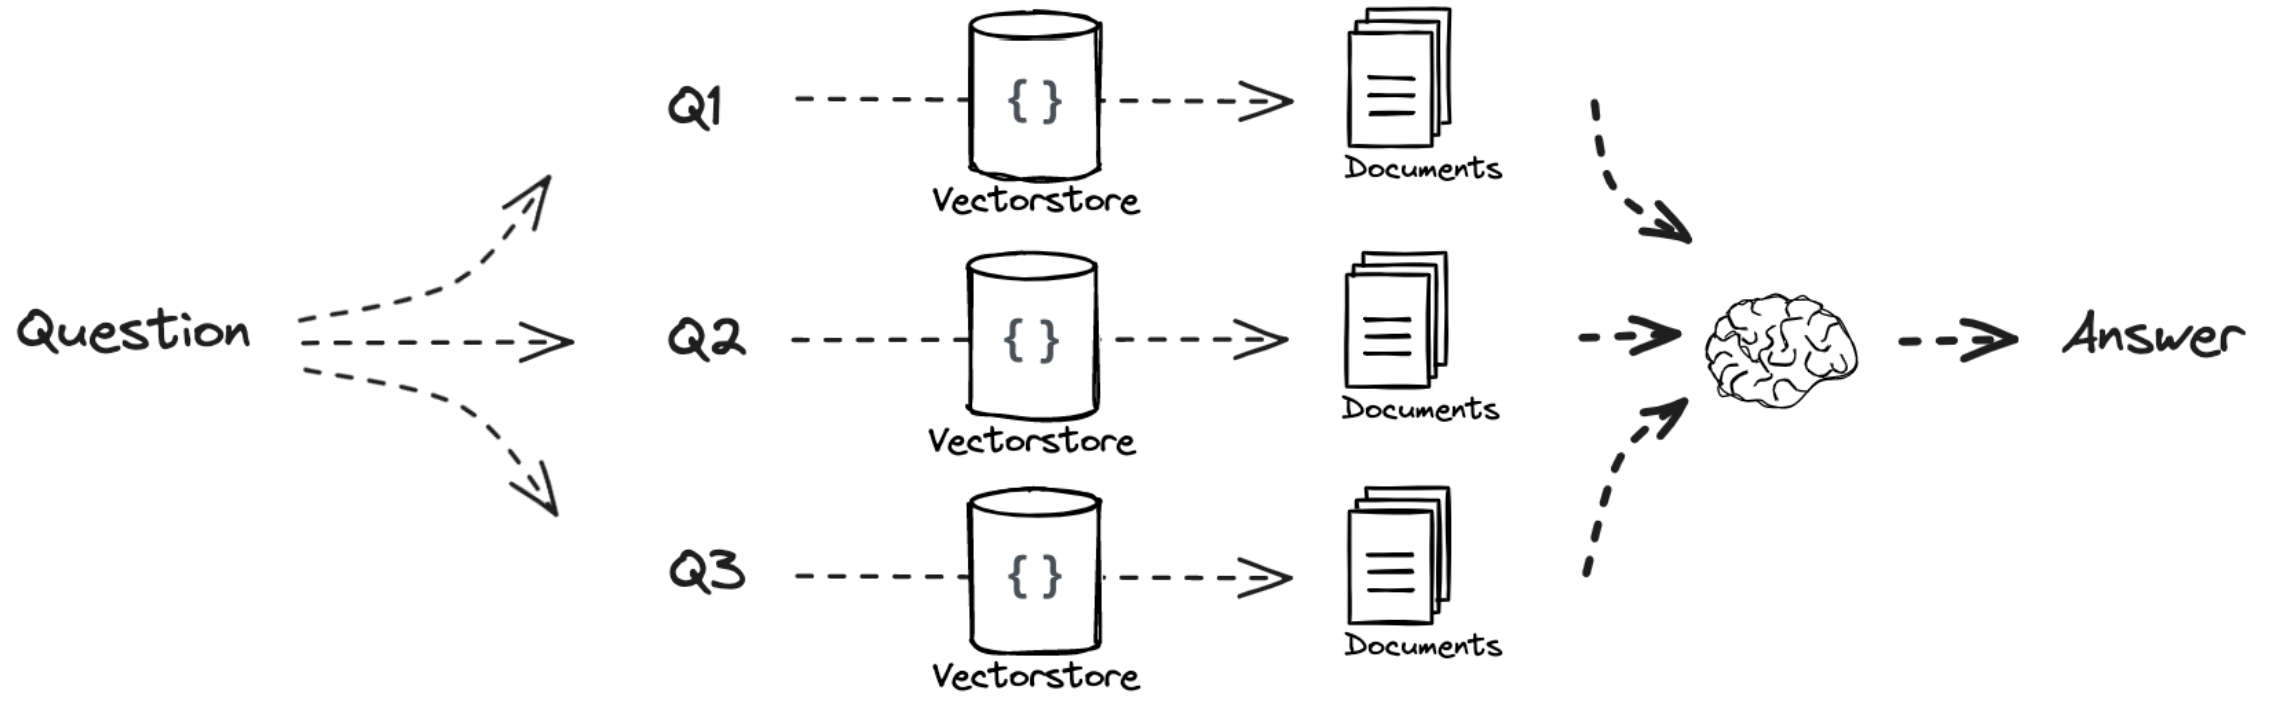

In [ ]:
from langchain.prompts import ChatPromptTemplate

# RAG-Fusion: Related
template = """You are a helpful assistant that generates multiple search queries based on a single input query. \n
Generate multiple search queries related to: {question} \n
Output (4 queries):"""
prompt_rag_fusion = ChatPromptTemplate.from_template(template)

from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI

generate_queries = (
    prompt_rag_fusion
    | ChatOpenAI(temperature=0)
    | StrOutputParser()
    | (lambda x: x.split("\n"))
)

question = "What are the identified climate-related risks described over the short, medium, or long term?"

queries = generate_queries.invoke({"question": question})
for query in queries:
    print(query)

1. What are the short-term climate-related risks identified by experts?
2. What are the medium-term climate-related risks that have been described by researchers?
3. What are the long-term climate-related risks that have been identified in scientific studies?
4. How do climate-related risks vary over the short, medium, and long term according to climate change projections?


RRF is primarily used to combine rankings from multiple sources or retrieval systems. It focuses on aggregating the results of different ranking algorithms rather than evaluating a single ranking list. It emphasizes diversity by combining ranks from multiple sources, making it less sensitive to the exact position of a document in one list.

**Mechanism:**

Reciprocal Rank Fusion (RRF) assigns a score to each document based on its rank across multiple rankings. The formula used for RRF is:

RRF = 1 / (k + r)

Where:
- `r` is the rank of a document in a particular ranking.
- `k` is a constant (often set to 60) to prevent domination by top-ranked results.

By combining the ranks from multiple sources, RRF helps to aggregate and balance the contributions from different ranking systems, promoting diversity in the final ranking.



In [ ]:
from langchain.load import dumps, loads

def reciprocal_rank_fusion(results: list[list], k=60):
    """ Reciprocal_rank_fusion that takes multiple lists of ranked documents
        and an optional parameter k used in the RRF formula """

    # Initialize a dictionary to hold fused scores for each unique document
    fused_scores = {}

    # Iterate through each list of ranked documents
    for docs in results:
        # Iterate through each document in the list, with its rank (position in the list)
        for rank, doc in enumerate(docs):
            # Convert the document to a string format to use as a key (assumes documents can be serialized to JSON)
            doc_str = dumps(doc)
            # If the document is not yet in the fused_scores dictionary, add it with an initial score of 0
            if doc_str not in fused_scores:
                fused_scores[doc_str] = 0
            # Retrieve the current score of the document, if any
            previous_score = fused_scores[doc_str]
            # Update the score of the document using the RRF formula: 1 / (rank + k)
            fused_scores[doc_str] += 1 / (rank + k)

    # Sort the documents based on their fused scores in descending order to get the final reranked results
    reranked_results = [
        (loads(doc), score)
        for doc, score in sorted(fused_scores.items(), key=lambda x: x[1], reverse=True)
    ]

    # Return the reranked results as a list of tuples, each containing the document and its fused score
    return reranked_results

retrieval_chain_rag_fusion = generate_queries | retriever.map() | reciprocal_rank_fusion
docs = retrieval_chain_rag_fusion.invoke({"question": question})
len(docs)

4

In [ ]:
from langchain_core.runnables import RunnablePassthrough

# RAG
template = """Answer the following question based on this context:

{context}

Question: {question}
"""

prompt = ChatPromptTemplate.from_template(template)

final_rag_chain = (
    {"context": retrieval_chain_rag_fusion,
     "question": itemgetter("question")}
    | prompt
    | llm
    | StrOutputParser()
)
question = "What are the identified climate-related risks described over the short, medium term for SwissRe and BlackRock?"
final_rag_chain.invoke({"question":question})

'The identified climate-related risks described over the short and medium term for Swiss Re include more frequent and intense heatwaves, air pollution from wildfires, vector-borne diseases, and mortality related to cold temperatures. For BlackRock, the risks include fluctuations in asset value due to climate-related risks leading to reduced investment management revenues.'

## Part 7: Query Decomposition

In [ ]:
from langchain.prompts import ChatPromptTemplate

# Decomposition
template = """You are a helpful assistant that generates multiple sub-questions related to an input question. \n
The goal is to break down the input into a set of sub-problems / sub-questions that can be answers in isolation. \n
Generate multiple search queries related to: {question} \n
Output (3 queries):"""
prompt_decomposition = ChatPromptTemplate.from_template(template)


from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser

# LLM
llm = ChatOpenAI(temperature=0)

# Chain
generate_queries_decomposition = ( prompt_decomposition | llm | StrOutputParser() | (lambda x: x.split("\n")))

# Run
question = "What are the metrics and targets set by the company for assessing and managing climate-related risks and opportunities, and for disclosing and setting targets for Scope 1, Scope 2, and Scope 3 GHG emissions??"
questions = generate_queries_decomposition.invoke({"question":question})

questions

['1. What are common metrics used by companies to assess climate-related risks and opportunities?',
 '2. How do companies set targets for reducing Scope 1, Scope 2, and Scope 3 greenhouse gas emissions?',
 '3. What are best practices for disclosing climate-related risks and setting targets for greenhouse gas emissions in corporate reporting?']

### Answer recursively  
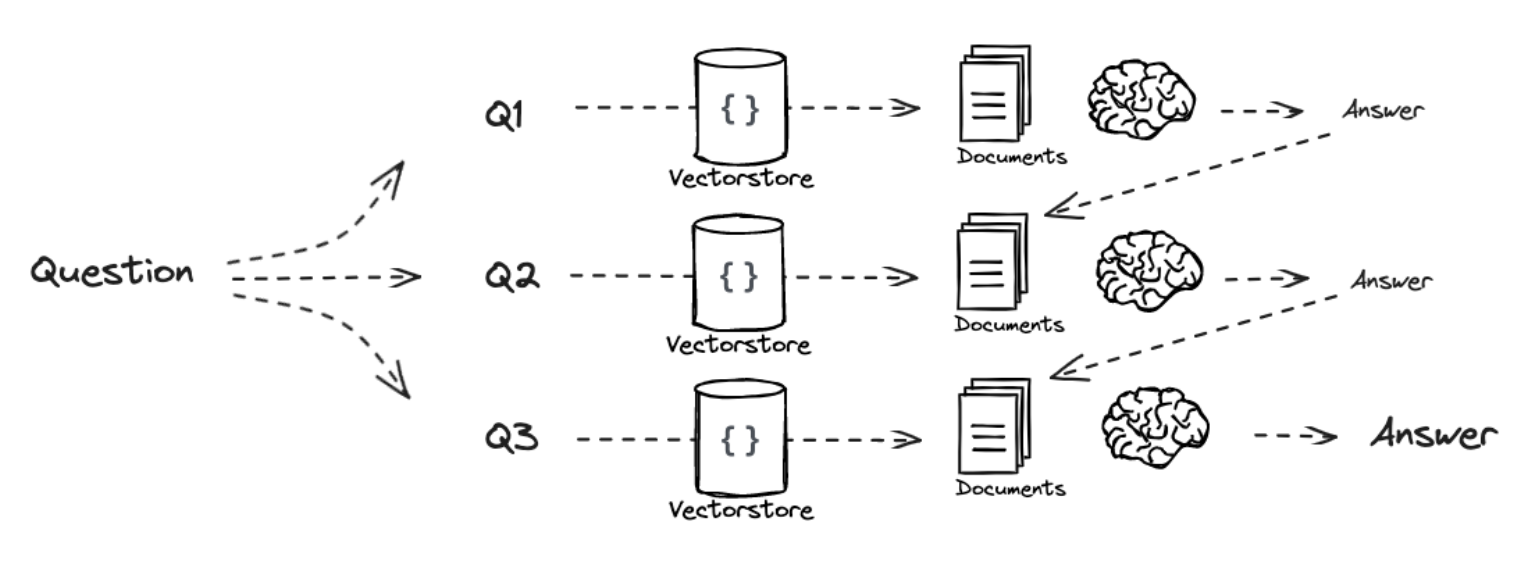


In [ ]:
# Prompt
template = """Here is the question you need to answer:

\n --- \n {question} \n --- \n

Here is any available background question + answer pairs:

\n --- \n {q_a_pairs} \n --- \n

Here is additional context relevant to the question:

\n --- \n {context} \n --- \n

Use the above context and any background question + answer pairs to answer the question: \n {question}
"""

decomposition_prompt = ChatPromptTemplate.from_template(template)

In [ ]:
from operator import itemgetter
from langchain_core.output_parsers import StrOutputParser

def format_qa_pair(question, answer):
    """Format Q and A pair"""

    formatted_string = ""
    formatted_string += f"Question: {question}\nAnswer: {answer}\n\n"
    return formatted_string.strip()

# llm
llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0)

q_a_pairs = ""
for q in questions:

    rag_chain = (
    {"context": itemgetter("question") | retriever,
     "question": itemgetter("question"),
     "q_a_pairs": itemgetter("q_a_pairs")}
    | decomposition_prompt
    | llm
    | StrOutputParser())

    answer = rag_chain.invoke({"question":q,"q_a_pairs":q_a_pairs})
    q_a_pair = format_qa_pair(q,answer)
    q_a_pairs = q_a_pairs + "\n---\n"+  q_a_pair

In [ ]:
answer

"Best practices for disclosing climate-related risks and setting targets for GHG emissions in corporate reporting include:\n\n1. Integrating processes for identifying, assessing, and managing climate-related risks into the organization's overall risk management.\n2. Disclosing metrics used to assess climate-related risks and opportunities in line with the organization's strategy and risk management process.\n3. Disclosing Scope 1, Scope 2, and potentially Scope 3 greenhouse gas (GHG) emissions, along with the related risks.\n4. Initiating steps towards compliance with frameworks like the Task Force on Climate-related Financial Disclosures (TCFD), focusing on governance, strategy, risk management, metrics, and targets.\n5. Establishing Science-Based Targets (SBTs) aligned with global climate goals to mitigate climate-related risks and capitalize on emerging opportunities.\n6. Embedding climate-related targets and actions into the organization's global Integrated Management System, Busin

### Answer individually
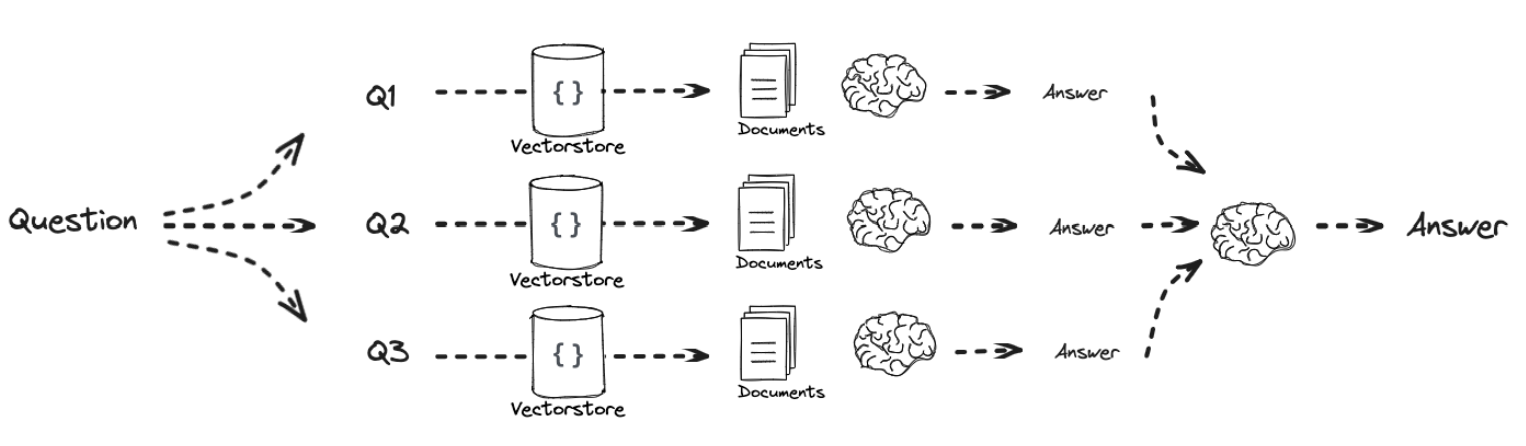

In [ ]:
# Answer each sub-question individually

from langchain import hub
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI

# RAG prompt
prompt_rag = hub.pull("rlm/rag-prompt")

def retrieve_and_rag(question,prompt_rag,sub_question_generator_chain):
    """RAG on each sub-question"""

    # Use our decomposition /
    sub_questions = sub_question_generator_chain.invoke({"question":question})

    # Initialize a list to hold RAG chain results
    rag_results = []

    for sub_question in sub_questions:

        # Retrieve documents for each sub-question
        #retrieved_docs = retriever.get_relevant_documents(sub_question)
        retrieved_docs = retriever.invoke(sub_question)

        # Use retrieved documents and sub-question in RAG chain
        answer = (prompt_rag | llm | StrOutputParser()).invoke({"context": retrieved_docs,
                                                                "question": sub_question})
        rag_results.append(answer)

    return rag_results,sub_questions

# Wrap the retrieval and RAG process in a RunnableLambda for integration into a chain
answers, questions = retrieve_and_rag(question, prompt_rag, generate_queries_decomposition)

In [ ]:
def format_qa_pairs(questions, answers):
    """Format Q and A pairs"""

    formatted_string = ""
    for i, (question, answer) in enumerate(zip(questions, answers), start=1):
        formatted_string += f"Question {i}: {question}\nAnswer {i}: {answer}\n\n"
    return formatted_string.strip()

context = format_qa_pairs(questions, answers)

# Prompt
template = """Here is a set of Q+A pairs:

{context}

Use these to synthesize an answer to the question: {question}
"""

prompt = ChatPromptTemplate.from_template(template)

final_rag_chain = (
    prompt
    | llm
    | StrOutputParser()
)

final_rag_chain.invoke({"context":context,"question":question})

'The company sets metrics such as Business Indicators, Corporate GHG Emissions, Firm-Level Climate Metrics, and Product-Level Sustainability Characteristics to assess and manage climate-related risks and opportunities. Targets are set to achieve net-zero GHG emissions by 2050, actively manage climate risk, support real economy transition, measure and monitor trajectory towards net zero, and inform shareholders and stakeholders transparently. For Scope 1, Scope 2, and Scope 3 GHG emissions, the company sets targets by disclosing emissions and related risks, reporting reliable source data, actively sourcing renewable electricity, and including categories such as fuel- and energy-related activities, waste generated in operations, business travel, and purchased goods and services in their emission reduction targets. The company follows best practices for disclosing climate-related risks and setting targets in corporate reporting, integrating climate-related risks and opportunities into ove

| **Aspect**             | **Recursive Approach**                                    | **Individual Approach**                                |
|------------------------|----------------------------------------------------------|--------------------------------------------------------|
| **Answer Aggregation**  | Combines multiple sources into a unified response         | Provides distinct answers for each source independently |
| **Depth vs Breadth**    | Emphasizes depth by integrating insights across sources   | Focuses on breadth, addressing each question separately |
| **Consistency**         | Ensures coherence across the entire response              | May lead to variations or redundancies in answers       |

For the question at hand, since climate-related risks and GHG emissions are interconnected (e.g., TCFD guidelines), a recursive approach could offer a better, holistic perspective. However, if the goal is to focus more on specific metrics and processes (e.g., how to track Scope 1-3 emissions distinctly), the individual approach might be more suitable for clarity.

## Part 8:Step Back
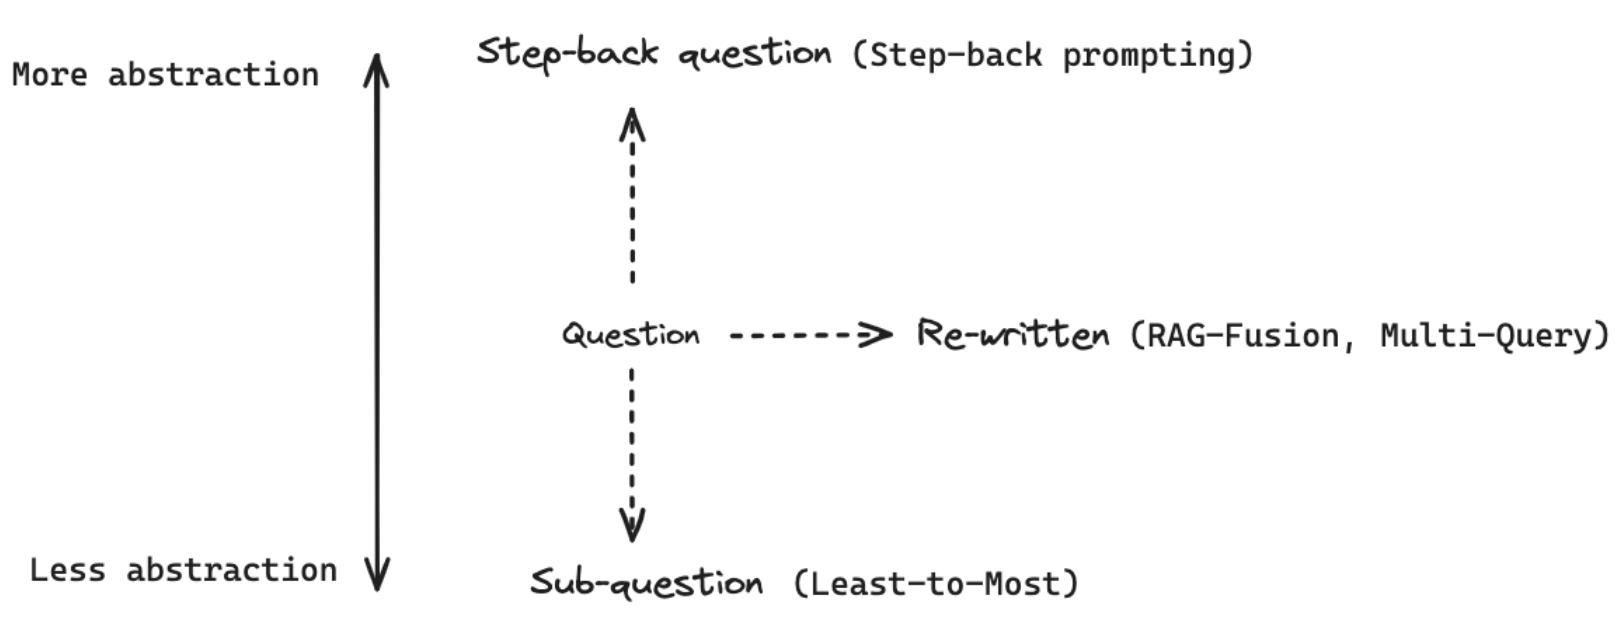

**Step 1: Define the Few-Shot Examples**

In [ ]:
from langchain_core.prompts import ChatPromptTemplate, FewShotChatMessagePromptTemplate

# Step 1: Define the Few-Shot Examples for TCFD
examples = [
    {
        "input": "Does the report include information on climate-related governance?",
        "output": "Yes, see page 15 of the report.",
    },
    {
        "input": "Does the report address physical climate risks?",
        "output": "No.",
    },
    {
        "input": "Does the report outline the company's climate-related targets?",
        "output": "Yes, see page 30 of the report.",
    },
    {
        "input": "Is there a section on scenario analysis?",
        "output": "Yes, see page 25 of the report.",
    },
    {
        "input": "Does the report provide a risk management framework for climate risks?",
        "output": "No.",
    },
]

# Step 2: Transform Examples to Messages

example_prompt = ChatPromptTemplate.from_messages(
    [
        ("human", "{input}"),
        ("ai", "{output}"),
    ]
)

# Step 3: Create Few-Shot Prompt Template
few_shot_prompt = FewShotChatMessagePromptTemplate(
    example_prompt=example_prompt,
    examples=examples
)

# Step 4: Define the Main Prompt
# Main Prompt Definition
prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are a specialized AI assistant trained to answer questions about reports, specifically related to the Task Force on Climate-related Financial Disclosures (TCFD). Users will ask you questions regarding TCFD-related topics, and your job is to provide accurate "yes" or "no" answers. When the answer is "yes," you must also provide the source, including the page number from the report where the information can be found.

Guidelines:

Understanding the Context:

Focus on TCFD-related questions, which may include aspects such as governance, strategy, risk management, metrics, and targets related to climate-related financial disclosures.
Answering Questions:

Respond with a clear "yes" or "no."
If the answer is "yes," provide a precise reference to the source, including the page number (e.g., "Yes, see page 42 of the report").
Handling Uncertainty:

If the information is not available or unclear, respond with "The report does not provide this information."
Referencing:

Always provide accurate page numbers for "yes" responses to ensure users can verify the information in the report.
Example Responses:

User: "Does the report include information on climate-related governance?"
AI: "Yes, see page 15 of the report."
User: "Does the report address physical climate risks?"
AI: "No."
Sample Interaction:

User: Does the report outline the company's climate-related targets?

AI: Yes, see page 30 of the report.

User: Is there a section on scenario analysis?

AI: Yes, see page 25 of the report.

User: Does the report provide a risk management framework for climate risks?

AI: No.

Follow these guidelines closely to ensure your answers are accurate, concise, and useful for the user.""",
        ),
        # Few shot examples
        few_shot_prompt,
        # New question
        ("user", "{question}"),
    ],
)

In [ ]:
generate_queries_step_back = prompt | ChatOpenAI(temperature=0) | StrOutputParser()
question = "What is the impact of climate-related risks and opportunities on business strategy and financial planning of SwissRe? Are climate scenarios, business resilience, transition plans, and residual emissions described?"
generate_queries_step_back.invoke({"question": question})

'The report does not provide this information.'

## Part 9: HyDE

HyDE generates a "hypothetical" response using a large language model (LLM) like GPT-4o-mini, then searches for matching embeddings based on that generated answer.

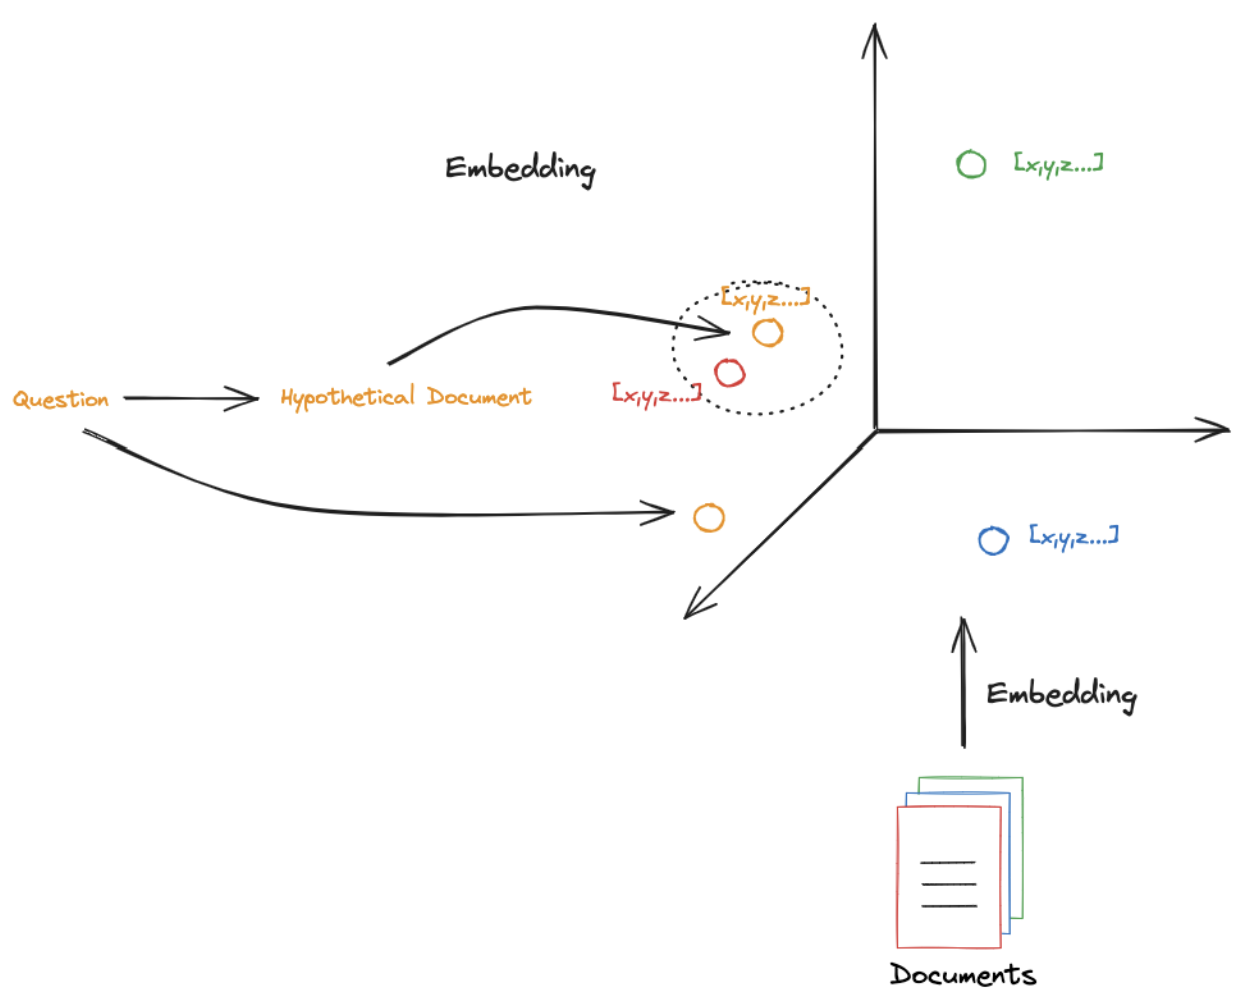

In [ ]:
from langchain.prompts import ChatPromptTemplate

# HyDE document genration
template = """Please write a scientific paper passage to answer the question
Question: {question}
Passage:"""
prompt_hyde = ChatPromptTemplate.from_template(template)

from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI

generate_docs_for_retrieval = (
    prompt_hyde | ChatOpenAI(temperature=0) | StrOutputParser()
)

# Run
question = "What are different investing considerations in SwissRe's investment portfolio and how could be ESG rating distribution across SwissRe' bond portfolio?"
generate_docs_for_retrieval.invoke({"question":question})

"SwissRe, as a leading reinsurance company, has a diverse investment portfolio that includes a range of asset classes such as equities, fixed income securities, and alternative investments. When considering investments, SwissRe takes into account various factors such as risk tolerance, liquidity needs, and investment objectives. \n\nOne important consideration in SwissRe's investment portfolio is environmental, social, and governance (ESG) factors. ESG considerations have become increasingly important in the investment community as investors seek to align their investments with their values and promote sustainable practices. SwissRe incorporates ESG criteria into its investment decision-making process to ensure that its investments are not only financially sound but also socially responsible.\n\nIn terms of the distribution of ESG ratings across SwissRe's bond portfolio, it is likely that the company would seek to invest in bonds issued by companies with strong ESG profiles. This could

In [ ]:
# Retrieve
retrieval_chain = generate_docs_for_retrieval | retriever
retireved_docs = retrieval_chain.invoke({"question":question})
retireved_docs

[Document(metadata={'author': '', 'creationDate': "D:20240311205134+01'00'", 'creator': 'Adobe InDesign 16.2 (Windows)', 'file_path': './data/reports/Sustainability/swissre_sustainability.pdf', 'format': 'PDF 1.6', 'keywords': '', 'modDate': "D:20240313092912+01'00'", 'page': 48, 'producer': 'Adobe PDF Library 15.0', 'source': './data/reports/Sustainability/swissre_sustainability.pdf', 'subject': 'Basic A4 / Version 0.1 / 18. 09. 2013 / Swiss Re - Media Production', 'title': '', 'total_pages': 135, 'trapped': ''}, page_content='described in the Overview of responsible \ninvesting considerations in Swiss Reʼs \ninvestment portfolio on page 54 an effective \nmeasure to limit exposure to companies with \nweaker sustainability and related financial \nperformance. This is reflected in the ESG \nrating profile of Swiss Re’s corporate bond \nportfolio1 as shown in the graph on page 48.\nFor its real estate portfolio, Swiss Re \nevaluates new investments in properties \nfrom an environmental a

In [ ]:
# RAG
template = """Answer the following question based on this context:

{context}

Question: {question}
"""

prompt = ChatPromptTemplate.from_template(template)

final_rag_chain = (
    prompt
    | llm
    | StrOutputParser()
)

final_rag_chain.invoke({"context":retireved_docs,"question":question})

"Different investing considerations in Swiss Re's investment portfolio include:\n1. Evaluating new investments in properties from an environmental and social perspective.\n2. Striving to improve the sustainability characteristics of properties already in the portfolio.\n3. Benchmarking US real estate investments against GRESB.\n4. Applying ESG rating thresholds for sovereign, supranational, and agency bonds.\n5. Implementing ESG benchmarks for actively managed listed equity and corporate bond mandates.\n\nThe ESG rating distribution across Swiss Re's bond portfolio shows a focus on companies with stronger sustainability and related financial performance. This is reflected in the ESG rating profile of Swiss Re's corporate bond portfolio, as shown in the graph on page 48 of the sustainability report. The company aims to limit exposure to companies with weaker sustainability performance and actively manages its bond mandates to align with ESG criteria."

Answer is based on figure from page 48 of the report
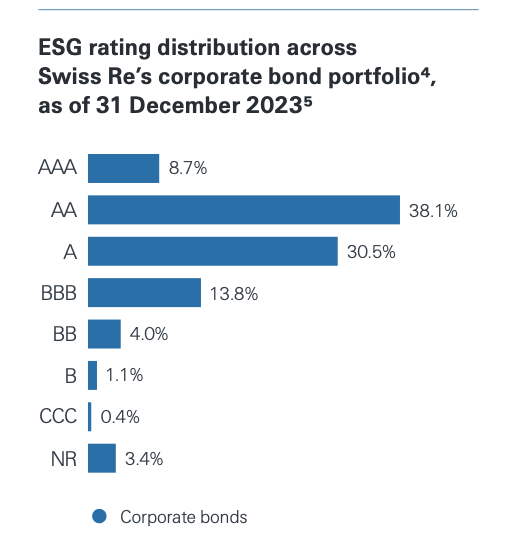

### Semantic routing

Semantic routing directs queries to the most relevant prompts or personas based on their semantic meaning, ensuring contextually accurate and tailored responses.

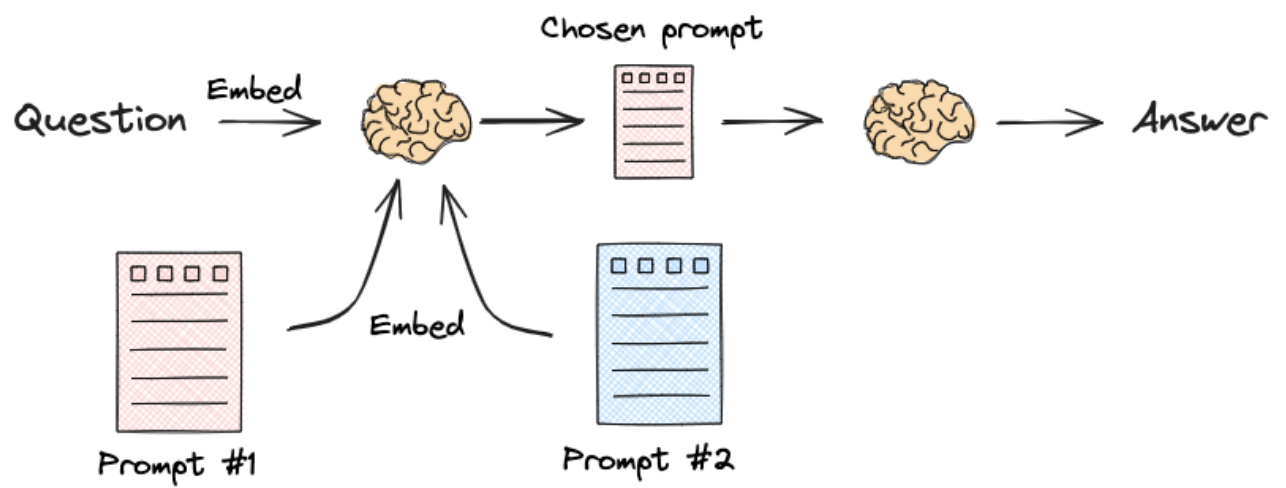

In [ ]:
from langchain.utils.math import cosine_similarity
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import RunnableLambda, RunnablePassthrough
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

# Two prompts
SustainabilityAnalystTemplate = """You are an expert assistant designed to help sustainability business analysts.
Provide comprehensive, accurate, and timely information on sustainability practices, including environmental impact, \
social responsibility, and economic viability. Your responses should be detailed, well-researched, and tailored to the \
specific needs of a sustainability business analyst. You need data, trend analysis, and reports on renewable energy options, \
waste reduction strategies, sustainable supply chain practices, and metrics for measuring social responsibility. \
Provide detailed and relevant information, including data sources, case studies, and relevant tools or frameworks.

Here is a question:
{query}"""

ChiefSustainabilityOfficerTemplate = """You are an expert assistant designed to help chief sustainability \
officers or chief financial officers. Provide high-level strategic insights, compliance information, and \
communication strategies for sustainability practices. Your responses should be detailed, well-researched, \
and tailored to the specific needs of a CSO or CFO. You need high-level data, compliance guidelines, risk analysis, \
and effective communication strategies for stakeholders regarding renewable energy, waste reduction, sustainable supply chains, \
and social responsibility metrics. Provide detailed and relevant information, including data sources, case studies, \
and relevant tools or frameworks.

Here is a question:
{query}"""

# Embed prompts
embeddings = OpenAIEmbeddings()
prompt_templates = [SustainabilityAnalystTemplate, ChiefSustainabilityOfficerTemplate]
prompt_embeddings = embeddings.embed_documents(prompt_templates)

# Route question to prompt
def prompt_router(input):
    # Embed question
    query_embedding = embeddings.embed_query(input["query"])
    # Compute similarity
    similarity = cosine_similarity([query_embedding], prompt_embeddings)[0]
    most_similar = prompt_templates[similarity.argmax()]
    # Chosen prompt
    print("Using Sustainability Analyst Persona" if most_similar == SustainabilityAnalystTemplate else "Using Chief Sustainability Officer Persona")
    return PromptTemplate.from_template(most_similar)


chain = (
    {"query": RunnablePassthrough()}
    | RunnableLambda(prompt_router)
    | ChatOpenAI()
    | StrOutputParser()
)

print(chain.invoke("How does SwissRe address impact of weather changes on agriculture reinsurance"))

Using Chief Sustainability Officer Persona
SwissRe, as a leading reinsurance company, is acutely aware of the impact that weather changes can have on the agriculture sector and the need to address these risks through sustainable practices. SwissRe has implemented various strategies to mitigate these risks and support sustainable agriculture practices.

One key strategy that SwissRe employs is the use of parametric insurance products for agriculture. Parametric insurance pays out based on predetermined triggers, such as rainfall levels or temperature thresholds, rather than actual losses. This type of insurance can help farmers receive timely payouts in the event of extreme weather events, providing them with the financial stability needed to recover and continue sustainable farming practices.

Additionally, SwissRe works closely with clients in the agriculture sector to develop risk management solutions tailored to their specific needs. This may include leveraging data analytics and mo